- Theoretical part
- definition of stability
- update rule

# Hopfield model project
Artificial Neural Networks (ANN) are computational techniques that aim to realize a very simplified model of the human brain. In this way, ANN try to learn tasks mimicking the behavior of brain. The brain is composed of a large set of elements, specialized cells called neurons. In analogy with the human brain, ANN are computational methods that use a large set of elementary computational: the neurons. Each single neuron is a very simple entity but the power of the brain is given by the fact that neurons are numerous and strongly interconnected between them. The human brain is one of the most computationally efficient device that is why in the late years a lot of effort has been done in order to develop an artificial version of it, as a matter of fact companies like Telsa motors are developing self driving cars which are based on ANN to implement the behavior of the human brain in computer systems. 

The easiest way to represent a neuron is either (on or off) or spin up/down in physics) with the synapsys either eccitative or inibitive. We can easily map the neural network into a spin system by mapping neurons in spins $\{s_i\}_{i=1,\cdots,N}$ and synapsys into the magnetic coupling $J_{ij}$.
By a specific representation of these coupling costant we can define the Hopfield model

$$
n = \{0,1\} \longrightarrow s = \{-1,1\}
$$
The correct transformation of this mapping is:
$$
\begin{equation}
s = f(n) = \frac{2n-1}{2}
\end{equation}
$$
We define the synapses as:
$$
J_{ij}=\begin{cases}
+1 & \mbox{ excitatory synapses} \\
-1 & \mbox{ inhibitory synapses}
\end{cases}
$$

A neuron is activated if he receive a sufficient number of active impulsive, and we can compute this impulses as:
$$
\begin{equation}
h_i(t) = \sum^N_{j=1,j\neq i} J_{ij}(s_j(t)+1)
\label{eq:h} 
\end{equation}
$$
It is important to notice that $j\neq i$ since the neuron DOES NOT interacts with himself.
To decide if this impulses are sufficient to activate the neuron we apply a non-linear function to the impulses:
$$
\begin{equation}
s_i(t+1)=sign{\left(h_i(t)-\theta_i\right)}
\end{equation}
$$
where $\theta_i$ is the threshold. We choose this threshold in a way that is useful for the calculations:
$$
\theta_i = \sum^N_{j=1,j\neq i} J_{ij}.
$$
By applying this threshold we obtain in Equation $\eqref{eq:upd}$ $\textbf{update rule}$ that we will use below in the code:
$$
\begin{equation}
s_i(t+1)=sign{\left(\sum^N_{j=1,j\neq i} J_{ij}s_j(t)\right)}
\label{eq:upd}
\end{equation}
$$

The $\textbf{Hopfield model}$ that we will use in the following consists in a specific choice of the synapses (ferromagnetic couplings):
$$
\
\begin{equation}
\begin{cases}
J_{ii}=0 & \mbox{ known as Hebb rule} \\
J_{ij}=\frac{1}{N}\sum_{\mu=1}^{p} \xi^\mu_i\xi^\mu_j
\end{cases}
\label{eq:hop}
\end{equation}
$$
where the $\vec{\xi^\mu}$ are $p<<N$ excitatory pattern with $\xi^\mu_i=\{+1,-1\}$.
This choice encode these patterns in the couplings and gives to the system some interesting properties:
- if the system start from a configuration equal to a pattern $\vec{\xi^\mu}$ and apply the update rule of Eq $\eqref{eq:upd}$ it stays in that pattern $\forall t$.
- by solving the system from a statistical mechanics point of view turns out that the system has many minima and this minima are all and only the patterns.

The actual resolution of this system is quite long and it is not the aim of this work, but it is instructive to see the proof of the stability of the patterns.
$$
s(1)=sign{\left(\sum^N_{j=1} J_{ij}s_j(0)\right)}\overset{s_j(0)=\xi^\mu_j}{=}
sign{\left(\sum^N_{j=1} \frac{1}{N}\sum^p_{\nu=1}\xi_i^\nu\xi_j^\nu\xi_j^\mu\right)} 
\\=sign{\left(\sum^N_{\nu=1}\xi_i^\nu\frac{1}{N}\sum^p_{j=1}\xi_j^\nu\xi_j^\mu \right)} 
=sign{\left(\sum^N_{\nu=1}\xi_i^\nu(\delta_{\mu\nu}+O(N^{-\frac{1}{2}}) \right)}
\simeq sign\left(\xi^\mu_i \right)=\xi^\mu_i
$$
And so the property enuciated before holds.

From now on we will talk about spins and not neurons anymore.

This model take into account fully connected system, where each spin is connected to all the others. But what happen if we consider an interaction lenght $R$? It is an interesting question to look at how the results vary with this assumption.

It is also really interesting to notice that this type of system does not need training, and so it can be reallly interesting if the results are good.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp

In [2]:
# Parameters
L = 10  # Lenght of the edge of the image
N = L**2 # Number of spins 
p = 10 # Number of patterns
MF = 0 # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
# a distance R interacts
R = 3 # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

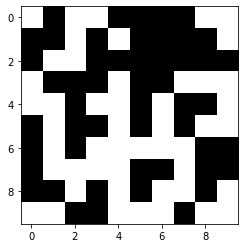

In [10]:
# Patterns
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

xi = random_patterns(N,p)
idx = np.random.randint(0,p)
plt.imshow(xi[idx].reshape(L,L),cmap='Greys') # This is an example of pattern 
# -1 = white, +1 = black

In [8]:
# Coupling constant
# Row i is the connections of the i-th neuron with the others.
# Note that the hopfield model requires Jii=0
# Note that J is a symmetrical matrix (J=J.T)
def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

In [9]:
global J
if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)

In [16]:
# Update rule
def update(sys):
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp +=  J[i][j]*sys[j] 
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys, t):
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction
    

The error of the algorithm is 0.185000
The algorithm recognised the pattern 2 and the correct pattern is 2


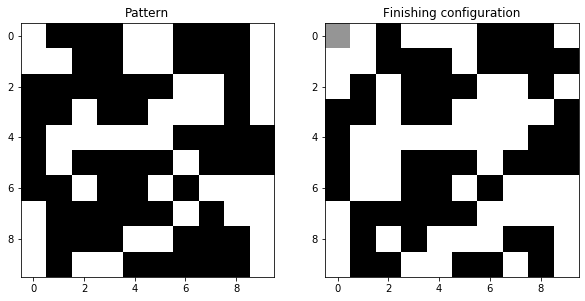

In [6]:
# actual algorithm
from copy import deepcopy
idx = np.random.randint(0,p)
sys = deepcopy(xi[idx])

sys = deterministic_hopfield(sys,100)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

## Analisys

In [17]:
# We now look at the scaling with regards to the parameters
L = 16
N = L**2
scores = []
errors = []

P = np.arange(5,N/2,20)
for p in P: 
    p = int(p)
    xi = random_patterns(N,p)
    if MF: J = MF_coupling(xi,N)
    else: J = R_coupling(xi,N,R)
    err, pred = total_error(xi,30)    
    scores.append( pred )
    errors.append(err)
        

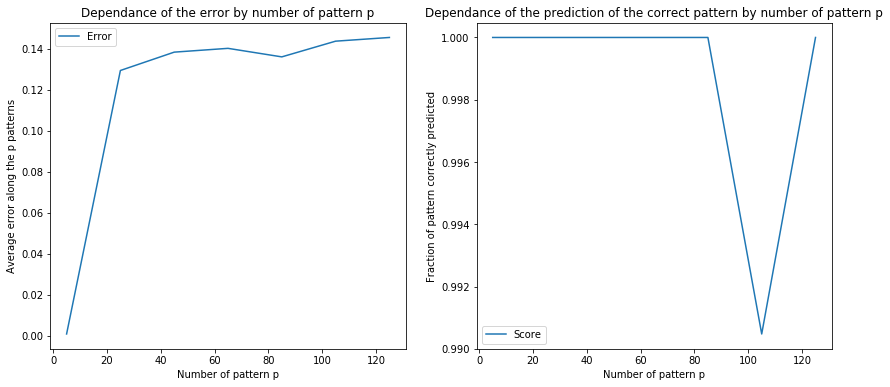

In [22]:
figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P,errors, label='Error')
axp[0].legend()

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P,scores, label='Score')
axp[1].legend()

In [ ]:
# How does the time scales with the number of spins N?
import time as time
L = np.arange(10,28,4)
N = L**2 
p = 10
times = []
for n in N:
    xi = np.random.randint(0,2,n*p).reshape(p,n)
    xi[xi==0]=-1
    J = 1/n * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(n) for j in range(n) ] )
    J = J.reshape(n,n)
    for k in range(len(J)):
        J[k,k] = 0
    idx = np.random.randint(0,p)
    start = time.time()
    deterministic_hopfield(xi[idx],30)
    end = time.time()
    times.append(end-start)

fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(N,times, label = 'Data with 10 patterns')
ax.set(xlabel = ' Number of spins N', ylabel =' Implementation time [s]', 
              title = '  Dependency of the time implementation on the size of the system')
ax.legend()

In [ ]:
# How does the time scales with the number of pattern p with a fixed N?
import time as time
L = 16
N = L**2 
P = np.arange(10,N,16)
times = []
for p in P:
    p = int(p)
    xi = np.random.randint(0,2,N*p).reshape(p,N)
    xi[xi==0]=-1
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)
    for k in range(len(J)):
        J[k,k] = 0
    idx = np.random.randint(0,p)
    start = time.time()
    deterministic_hopfield(xi[idx],30)
    end = time.time()
    times.append(end-start)

fig, ax = plt.subplots(figsize = (10.5, 10))
ax.plot(P,times, label = 'Data with 16x16 spins')
ax.set(xlabel = 'Number of patterns p', ylabel =' Implementation time [s]', 
              title = ' Dependency of the time implementation on the number of patterns')
ax.legend()